In [1]:
import csv
import itertools
import time
import timeit

import numpy as np

from skimage.filters import threshold_mean
from skimage.morphology import skeletonize
from skimage import graph as skgraph

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

from utils.plotting import *
from utils.process import *

# Intro

## Read in MNIST data

In [2]:
mnist_filename = '../data/mnist/mnist_test.csv'
mnist_images_raw, mnist_labels = read_in_mnist(mnist_filename)


In [3]:
print(len(mnist_images_raw))
print(len(mnist_labels))


10000
10000


## A full processing pipeline

### Test the full processing pipeline's runtime

`timeit.default_timer()` measurements can be affected by other programs running on the same machine, so the best thing to do when accurate timing is necessary is to repeat the timing a few times and use the best time. The `-r` option is good for this; the default of 5 repetitions is probably enough in most cases. You can use `time.process_time()` to measure CPU time.

But we can only use `-r` for repetitions from the command line.

In [4]:
def TGGLinesPlus(image, idx, connectivity=2):
    """
    This method is currently designed for one image, though it also works for lists of images. 
    For instance, you can use a list comprehension on a list of input images like so: 
        output_images = [TGGLinesPlus(image) for image in input_images]

    Parameters:
        image: the input image

        connectivity: an int value
            1 represents vertical and horizontal edges in a graph
            2 represents horizontal, vertical, and diagonal edges (full triangle: two lengs and the hypotenuse)

    Returns:
        a dictionary of important values and objects generated during the method

    """
    # set default values for variables that depend on the value of connectivity
    neighbor_locations = None
    neighbor_values = None
    current_degrees = None
    
    # create binary image
    thresh = threshold_mean(image)
    binary = image > thresh
    
    # create skeleton, pad image
    # pad skeleton image AFTER thresholding, otherwise it can affect the resulting skeleton
    skeleton = skeletonize(binary)
    skeleton = pad_image(skeleton)

    # then convert to scipy sparse array
    skeleton_array, skeleton_coords = create_skeleton_graph(skeleton, connectivity=connectivity)

    # create graph from scipy sparse array, get node locations and save as dict
    skeleton_graph_original = nx.from_scipy_sparse_array(skeleton_array)
    search_by_node, search_by_location = get_node_locations(skeleton_coords)
    
    if(connectivity == 1):
        # if connectivity = 1, then skimage will only add vertical and horizontal edges to the graph
        # so we need to find the diagonal edges and add them to our graph

        # find neighboring pixels and their values
        neighbor_locations = [find_neighbors(pixel) for pixel in skeleton_coords]
        neighbor_values = get_neighbor_values(neighbor_locations, skeleton)

        # identify degree mismatch for each node in graph
        # if degree mismatch exists, compile a list of each node where this is true in nx_graph
        potential_degrees = get_node_degree(neighbor_values)
        current_degrees = [val for (node, val) in skeleton_graph_original.degree()]
        problem_nodes = list(np.where(np.array(potential_degrees) - np.array(current_degrees) != 0)[0])

        # find problem nodes
        node_neighbors = node_in_neighbors(neighbor_locations, skeleton_coords)
        problem_node_neighbor_idx = [node_neighbors[idx] for idx in problem_nodes]

        # update any missing connections between neighboring nodes in nx_graph
        skeleton_graph_updated = add_missing_connections(problem_nodes, problem_node_neighbor_idx, search_by_location, skeleton_graph_original)
    else:
        skeleton_graph_updated = skeleton_graph_original

    # calculate final node degrees and node types from updated graph
    degrees = [val for (node, val) in skeleton_graph_updated.degree()]
    node_types = list(map(degree_to_node_type, degrees))

    # create NetworkX subgraph from junction nodes to find cliques
    junction_locations = list(np.where(np.array(node_types)=="J")[0])
    junction_subgraph = nx.subgraph(skeleton_graph_updated, nbunch=junction_locations)

    # find cliques and primary junction nodes
    cliques, unique_cliques = get_unique_cliques(junction_subgraph, junction_locations)

    # from here, we want to find primary junctions, which are either:
    #   - solo junctions: a junction (by definition with 3+ connections) not connected to any other junctions
    #   - triangle cliques: junctions that form right triangles with themselves
    cliques_1_single_junction = [clique for clique in unique_cliques if len(clique) == 1]
    cliques_1_single_junction = flatten_list(cliques_1_single_junction)

    cliques_3_right_triangles = set([find_primary_junctions(clique, search_by_node) for clique in unique_cliques if len(clique) == 3])
    cliques_3_right_triangles = sorted(list(cliques_3_right_triangles))

    edges_to_remove = [find_removable_edges(clique, search_by_node) for clique in unique_cliques if len(clique) == 3]
    path_seg_graph = skeleton_graph_updated.copy()
    path_seg_graph.remove_edges_from(edges_to_remove)

    # make sure that we successfully subtracted the right number of edges
    num_edges = len(skeleton_graph_updated.edges()) - len(path_seg_graph.edges()) 
    assert(num_edges == len(edges_to_remove))

     # AFTER we find cliques_3_right_triangles, we can find cliques_2_adjacent_nodes
    # after we remove edges, some nodes lose that edge and are no longer junctions (3+ connections)
    # we can ignore these nodes and only focus on "branching" nodes, or nodes that look like a Y (i.e., they become cliques_1_single_junction nodes)
    adjacent_junctions_list = [clique for clique in unique_cliques if len(clique) == 2]
    adjacent_junctions_list = sorted(list(set(flatten_list(adjacent_junctions_list))))
    cliques_2_adjacent_junctions = [node for node in adjacent_junctions_list if len(path_seg_graph.edges(node)) >= 3]

    # for path segmentation, we also want to include "terminal" end nodes
    # the location in node_types is the same node number in graph
    end_nodes = list(np.where(np.array(node_types) == "E")[0])

    primary_junctions = sorted(cliques_1_single_junction + cliques_2_adjacent_junctions + cliques_3_right_triangles)
    path_seg_endpoints = sorted(cliques_1_single_junction + cliques_2_adjacent_junctions + cliques_3_right_triangles + end_nodes)
    # print("Path segmentation endpoints: ")
    # print(path_seg_endpoints)
    #### path segmentation ####
    paths_list = segment_paths(path_seg_graph, path_seg_endpoints)

    if(len(paths_list) == 0):
        """
        In most cases, there will be at least one end node or junction node. 
        But in a special case where the graph is perfectly circular (not in a geometric case, but in the sense each node leads to the next in a circular manner), 
        then the path of the graph should be the graph itself.
        """
        # find which other nodes the first node is connected to
        # 0 is the top, left-most node in NetworkX
#         left_right_connection_nodes = [node for node in flatten_list(list(path_seg_graph.edges(0))) if node != 0]
        
#         potential_paths = [list(nx.all_simple_paths(path_seg_graph, 0, node)) for node in left_right_connection_nodes]
#         # since the nodes in left_right_connection_nodes are adjacent to node 0, 
#         # two of the paths will be [0, x], [0, y]; but we want the full paths that complete the full graph circle
#         potential_paths = [sublist for sublist in flatten_list(potential_paths) if len(sublist) > 2]
#         print(potential_paths)
        
#         paths_list = sorted(potential_paths)[0]
        print("Problem image: {}".format(idx))

    # return the updated graph object and important info as dict
    return {
        "cliques": cliques,
        "cliques_unique": unique_cliques,
        "cliques_1_single_junction": cliques_1_single_junction,
        "cliques_2_adjacent_junctions": cliques_2_adjacent_junctions,
        "cliques_3_right_triangles": cliques_3_right_triangles,
        "endpoints_path_seg": path_seg_endpoints,
        "junction_locations": junction_locations,
        #"junction_subgraph": junction_subgraph,
        "junctions_primary": primary_junctions,
        #"neighbor_locations": neighbor_locations,
        #"neighbor_values": neighbor_values,
        "node_degrees": degrees,
        #"node_degrees_before_update": current_degrees,
        "node_types": node_types,
        "nodes_terminal": end_nodes,
        "paths_list": paths_list,
        "removed_edges": edges_to_remove,
        "search_by_location": search_by_location,
        "search_by_node": search_by_node,
        "skeleton": skeleton,
        "skeleton_coordinates": skeleton_coords,
        "skeleton_graph": skeleton_graph_updated,
        "skeleton_graph_original": skeleton_graph_original,
        "skeleton_graph_path_seg": path_seg_graph,
    }

In [5]:
start = timeit.default_timer()
#start = time.process_time()

#result_dict_list = [TGGLinesPlus(img) for img in mnist_images_raw]
result_dict_list = [TGGLinesPlus(img, idx) for idx, img in enumerate(mnist_images_raw)]

stop = timeit.default_timer()
#stop = time.process_time()

print(f"Time to run: {(stop - start):.5f}s")  


Problem image: 10
Problem image: 13
Problem image: 28
Problem image: 55
Problem image: 69
Problem image: 71
Problem image: 101
Problem image: 110
Problem image: 126
Problem image: 136
Problem image: 148
Problem image: 183
Problem image: 188
Problem image: 192
Problem image: 194
Problem image: 215
Problem image: 246
Problem image: 269
Problem image: 271
Problem image: 294
Problem image: 296
Problem image: 311
Problem image: 312
Problem image: 327
Problem image: 346
Problem image: 365
Problem image: 372
Problem image: 407
Problem image: 424
Problem image: 440
Problem image: 443
Problem image: 459
Problem image: 485
Problem image: 498
Problem image: 525
Problem image: 545
Problem image: 546
Problem image: 552
Problem image: 567
Problem image: 572
Problem image: 592
Problem image: 597
Problem image: 608
Problem image: 642
Problem image: 644
Problem image: 694
Problem image: 701
Problem image: 704
Problem image: 713
Problem image: 721
Problem image: 742
Problem image: 750
Problem image: 763

Problem image: 6383
Problem image: 6424
Problem image: 6429
Problem image: 6435
Problem image: 6442
Problem image: 6444
Problem image: 6454
Problem image: 6461
Problem image: 6484
Problem image: 6489
Problem image: 6493
Problem image: 6510
Problem image: 6514
Problem image: 6588
Problem image: 6603
Problem image: 6621
Problem image: 6633
Problem image: 6672
Problem image: 6701
Problem image: 6711
Problem image: 6719
Problem image: 6750
Problem image: 6752
Problem image: 6753
Problem image: 6760
Problem image: 6779
Problem image: 6781
Problem image: 6798
Problem image: 6808
Problem image: 6833
Problem image: 6843
Problem image: 6864
Problem image: 6877
Problem image: 6892
Problem image: 6921
Problem image: 6923
Problem image: 6925
Problem image: 6927
Problem image: 6937
Problem image: 6947
Problem image: 6959
Problem image: 6968
Problem image: 6970
Problem image: 6978
Problem image: 7031
Problem image: 7037
Problem image: 7072
Problem image: 7086
Problem image: 7129
Problem image: 7146


#### Timing
So the entire MNIST dataset takes about `~37-38s` to run with `connectivity=1` and `~19-28s` to run with `connectivity=2` (the default).

In [6]:
# pick a random image and plot the skeleton graph's paths
# good example to work with: number 8 at index 3406
# idx = np.random.randint(0, len(result_dict_list))
idx = 3406
label = mnist_labels[idx]
result_dict = result_dict_list[idx]

# the image skeleton and graph are include in result_dict
# but we need them for the plot_networkx_graph() method
skeleton = result_dict["skeleton"]
graph = result_dict["skeleton_graph"]
coordinates = result_dict["skeleton_coordinates"]

### This is how each plotting method should be called.

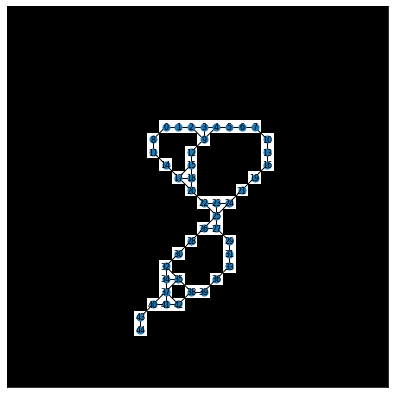

In [7]:
plot_networkx_graph(skeleton, graph, coordinates)


In [8]:
# the before and after graphs are only different if connectivity=1
# display_updated_graphs(result_dict)


In [9]:
# plot_junctions(result_dict, label, idx)


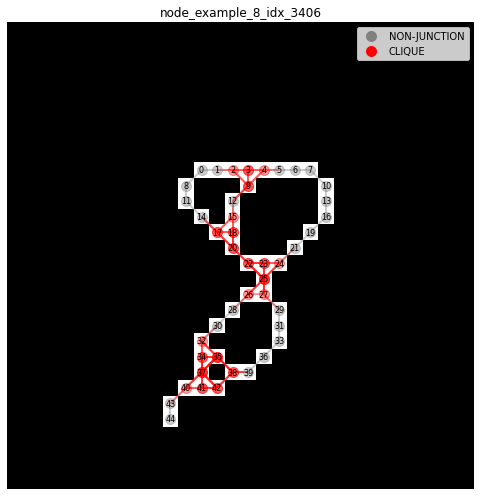

In [10]:
plot_cliques(result_dict, label, idx)


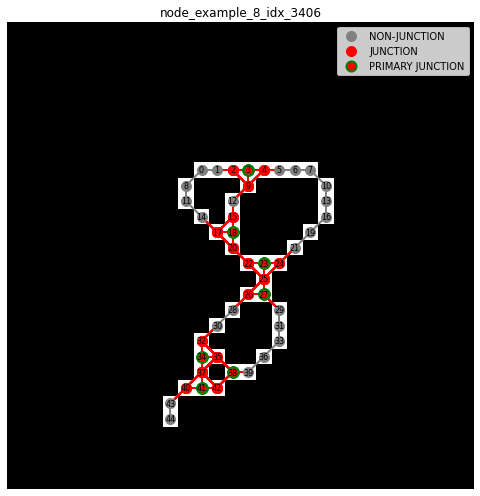

In [11]:
plot_primary_junctions(result_dict, label, idx)


## Path segmentation

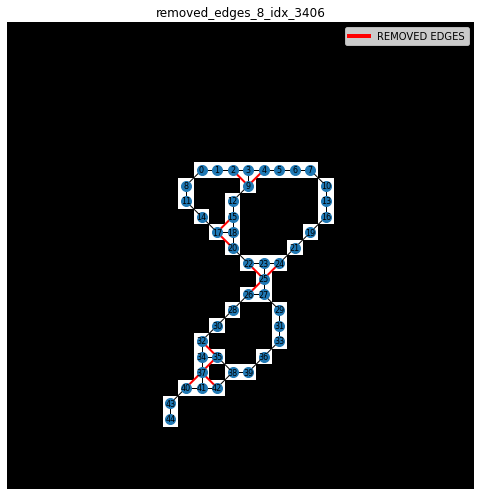

In [12]:
plot_removed_edges(result_dict, label, idx)

### Walking from terminals-junctions and junctions-junctions

As a reminder, here is how we currently define different junction types: <br>
**J**: *junction node*, `degree >= 3` <br>
**T**: *turning node*, `degree = 2` <br>
**E**: *end node*, `degree = 1` <br>
**I**: *isolated node*, `degree = 0` <br>

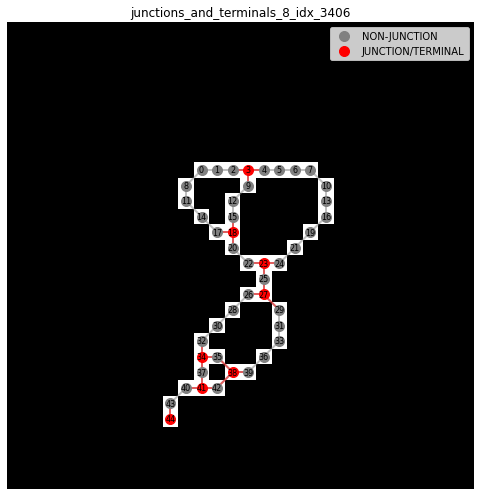

In [13]:
plot_junctions_and_terminals(result_dict, label, idx)

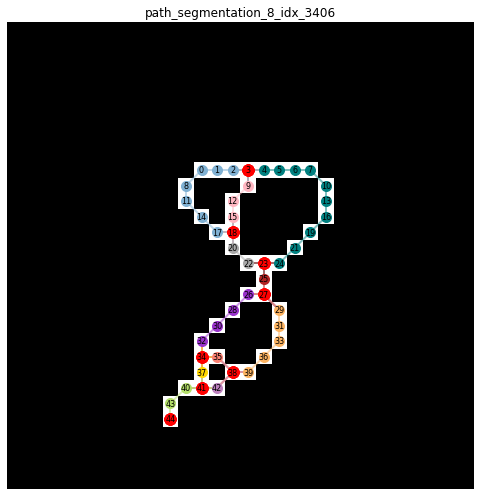

In [15]:
plot_graph_paths(result_dict, label, idx)

## Interesting examples: no junctions

In most cases, there will be at least one end node or junction node. But in a special case where the graph is perfectly circular (not in a geometric case, but in the sense each node leads to the next in a circular manner), then the path of the graph should be the graph itself.

In [16]:
# index 10 has no junction or end nodes
idx = 10
label = mnist_labels[idx]
result_dict = result_dict_list[idx]

path_seg_graph = result_dict["skeleton_graph_path_seg"]


In [17]:
paths_list = result_dict["paths_list"]
paths_list


[]

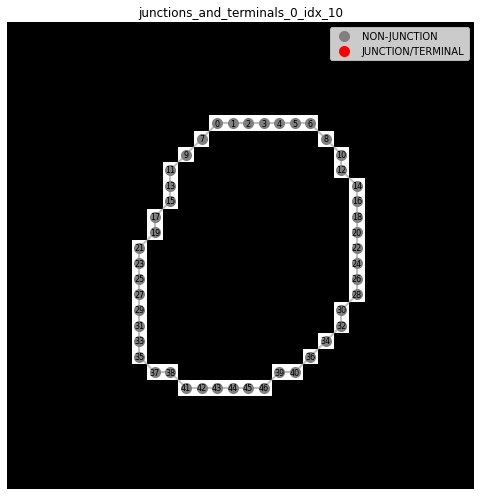

In [18]:
# no junctions, no terminals
plot_junctions_and_terminals(result_dict, label, idx)


In [19]:
left_right_connection_nodes = [node for node in flatten_list(list(path_seg_graph.edges(0))) if node != 0]

potential_paths = [list(nx.all_simple_paths(path_seg_graph, 0, node)) for node in left_right_connection_nodes]
# since the nodes in left_right_connection_nodes are adjacent to node 0, 
# two of the paths will be [0, x], [0, y]; but we want the full paths that complete the full graph circle
potential_paths = [sublist for sublist in flatten_list(potential_paths) if len(sublist) > 2]

result_dict["paths_list"] = [sorted(potential_paths)[0]]

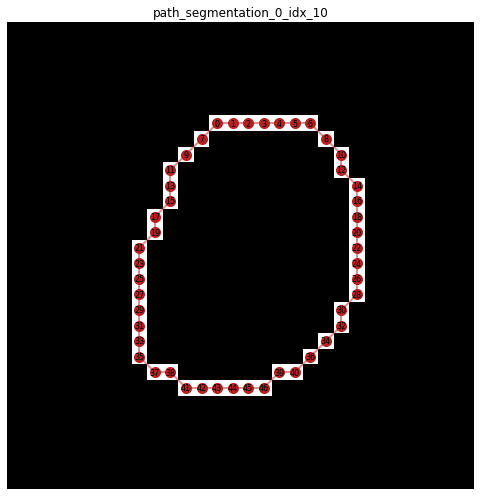

In [20]:
# but we can still find the path that spans the graph
plot_graph_paths(result_dict, label, idx)


## Interesting examples: multiple graphs

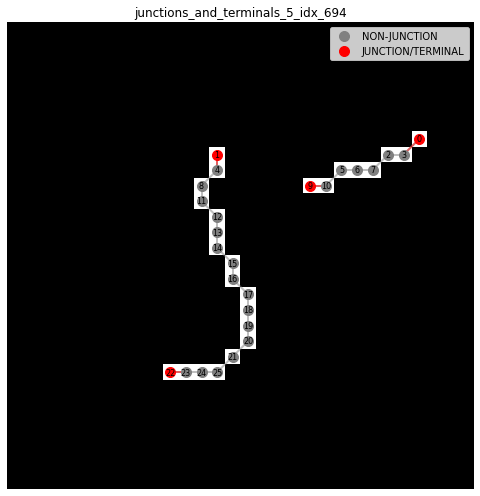

In [21]:
idx = 694
label = mnist_labels[idx]
result_dict = result_dict_list[idx]
plot_junctions_and_terminals(result_dict, label, idx)

## Other interesting examples

Let's examine the list of other interesting examples that we've previously saved.

In [22]:
# this list is length 18
interesting_examples_list = [1061, 1438, 1762, 1775, 2649, 3266,
                            3624, 3864, 3894, 4923, 5108, 5847, 
                             6344, 6428, 8493, 8865, 8951, 9688]

# this list is length 14
complex_examples_list = [620, 1411, 2023, 2358, 2638, 
                         3073, 3450, 3646, 4611, 4759,
                        5593, 7536, 9508, 9948]

# idx = interesting_examples_list[0]
# idx = complex_examples_list[0]
idx = 5165
label = mnist_labels[idx]
result_dict = result_dict_list[idx]


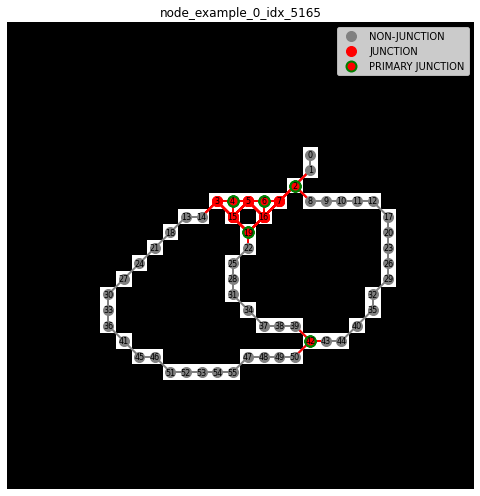

In [23]:
plot_primary_junctions(result_dict, label, idx)


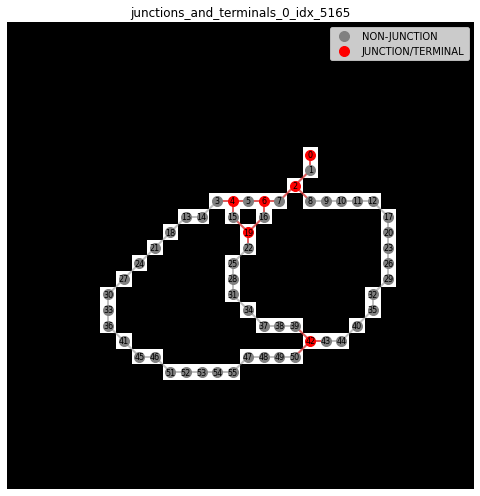

In [24]:
plot_junctions_and_terminals(result_dict, label, idx)

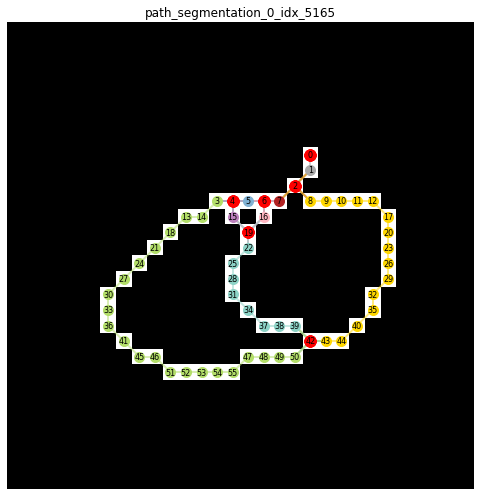

In [25]:
plot_graph_paths(result_dict, label, idx)
